# 프로젝트 : 스티커를 붙여주자

[학습 코드로 이동](./0311_face_detection.ipynb)  
[Focal loss 학습 코드로 이동](./0311_face_detection-loss.ipynb)  

- Step 1. 스티커 구하기 혹은 만들기
- Step 2. SSD 모델을 통해 얼굴 bounding box 찾기
  - 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 검출
  - inference.py 코드를 적극적으로 참고
- Step 3. dlib 을 이용한 landmark 찾기 (선택사항)
  - 검출된 bounding box에 dlib을 적용해 face landmark를 찾을 수 있음
  - dlib를 이용하려는 경우, inference.py 에서 show_image 메소드를 사용한 부분을 적절히 수정
- Step 4. 스티커 합성 사진 생성하기

In [1]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [2]:
import tensorflow as tf
import numpy as np
import cv2

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.6.0
1.21.4
4.5.3


### Step 1. 스티커 구하기 혹은 만들기

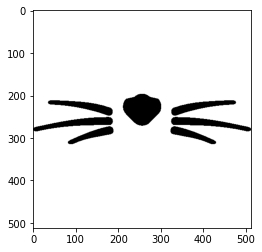

In [3]:
sticker_filename = 'mustache.png'
img_sticker = cv2.imread(sticker_filename)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

### Step 2. SSD 모델을 통해 얼굴 bounding box 찾기
  - 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 검출
  - inference.py 코드를 적극적으로 참고

#### Default boxes
![default_boxes](https://manalelaidouni.github.io/assets/img/pexels/SSD.jpg)  
- object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것
- 다른 말로 anchor, prior box
- Default box 필요 : SSD 모델의 가장 중요한 특징 중 하나
- SSD 모델에서의 default box는 여러 층의 feature map에서 box를 만들어 냄
  - 층 수 만큼 box 수도 많아지고, 층마다 box의 크기도 다양함
- ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택
  - RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서도 그와 유사한 정도의 정확도를 얻을 수 있음


![feature_maps](https://towardsdatascience.com/wp-content/uploads/2017/11/1JuhjYUWXgfxMMoa4SIKLkA.png)  

In [4]:
# 프로젝트에서 사용할 default box 정보를 전역 변수로 정의
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [5]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    
    # default box를 생성하기 위해서는 먼저 기준이 되는 feature map 생성
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    
    boxes = []
    # feature map별로 순회를 하면서 default box 를 생성
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    
    # 생성된 boxes에는 default box 정보가 구분없이 나열되어 있으므로 4개씩 재배열
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

#### SSD model 빌드

In [6]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [7]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [8]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

- 여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 헤드(head) 라고 불리는 Convolution 레이어를 붙임
- 하나의 헤드에 Convolution 레이어 두 개가 필요
- 하나는 confidence를 예측하기 위해 사용하고 다른 하나는 location을 예측하기 위해 사용

In [9]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [10]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

- SSD model

In [11]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [12]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

- 101층의 SSD 모델

In [13]:
model = SsdModel()

### NMS 구현
- Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요

In [14]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [15]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [16]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

- 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과 생성

In [17]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [18]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

### 사진에서 얼굴 찾기
- 우선 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수

In [19]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [20]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

- 최종 결과를 시각화

In [21]:
def draw_box_on_face(raw_image, boxes, classes, scores, box_index, class_list):
    img = raw_image.copy()
    
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))
        
    plt.imshow(img)
    plt.show()

In [22]:
def predict_faces(model, weight_path, image_path, w=IMAGE_WIDTH, h=IMAGE_HEIGHT, labes=IMAGE_LABELS, debug=False):
    if weight_path is not None:
        model.load_weights(weight_path)
        
    raw_image = cv2.imread(image_path)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    
    image = cv2.resize(raw_image, (w, h))
    image = np.float32(image.copy())
    
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, pad_params = pad_input_image(image, max_steps=max(BOX_STEPS))
    image = image / 255.0
    
    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
    
    predictions = model.predict(image[np.newaxis, ...])
    
    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)
    
    if debug:
        print(pred_boxes)

        for box_index in range(len(pred_boxes)):
            draw_box_on_face(raw_image, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
    
    if len(pred_boxes) < 1:
        raise Exception(f'Cannot find the face.')
    
    return raw_image, pred_boxes

In [23]:
weightpath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
imagepath = os.path.join(PROJECT_PATH, 'image_people.png')

predict_faces(model, weightpath, imagepath)

(array([[[154, 172, 184],
         [142, 162, 173],
         [148, 168, 179],
         ...,
         [ 73, 108,  86],
         [ 70, 103,  84],
         [ 65,  98,  79]],
 
        [[156, 174, 186],
         [143, 163, 174],
         [149, 169, 180],
         ...,
         [ 82, 117,  93],
         [ 78, 113,  91],
         [ 72, 105,  84]],
 
        [[161, 179, 189],
         [150, 170, 179],
         [154, 174, 183],
         ...,
         [ 82, 118,  92],
         [ 83, 119,  93],
         [ 81, 116,  92]],
 
        ...,
 
        [[ 14,  27,  35],
         [ 14,  27,  35],
         [ 17,  30,  38],
         ...,
         [ 40,  56,  53],
         [ 45,  61,  58],
         [ 40,  56,  53]],
 
        [[ 13,  26,  34],
         [ 14,  27,  35],
         [ 16,  29,  37],
         ...,
         [ 43,  59,  56],
         [ 42,  58,  55],
         [ 31,  50,  46]],
 
        [[ 13,  26,  34],
         [ 13,  26,  34],
         [ 15,  28,  36],
         ...,
         [ 37,  53,  50],
  

[[0.09641881 0.06608966 0.31523868 0.3633395 ]
 [0.55504614 0.21640016 0.77819175 0.52138424]
 [0.690304   0.25674397 0.88896734 0.5340832 ]
 [0.3485098  0.22869615 0.565535   0.5223213 ]]


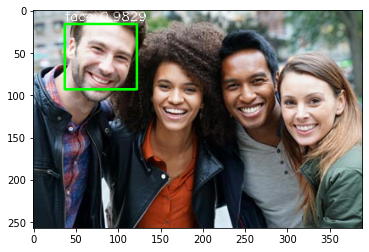

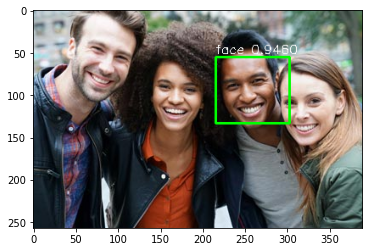

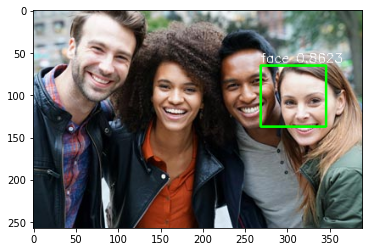

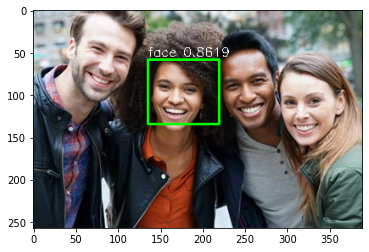

(array([[[154, 172, 184],
         [142, 162, 173],
         [148, 168, 179],
         ...,
         [ 73, 108,  86],
         [ 70, 103,  84],
         [ 65,  98,  79]],
 
        [[156, 174, 186],
         [143, 163, 174],
         [149, 169, 180],
         ...,
         [ 82, 117,  93],
         [ 78, 113,  91],
         [ 72, 105,  84]],
 
        [[161, 179, 189],
         [150, 170, 179],
         [154, 174, 183],
         ...,
         [ 82, 118,  92],
         [ 83, 119,  93],
         [ 81, 116,  92]],
 
        ...,
 
        [[ 14,  27,  35],
         [ 14,  27,  35],
         [ 17,  30,  38],
         ...,
         [ 40,  56,  53],
         [ 45,  61,  58],
         [ 40,  56,  53]],
 
        [[ 13,  26,  34],
         [ 14,  27,  35],
         [ 16,  29,  37],
         ...,
         [ 43,  59,  56],
         [ 42,  58,  55],
         [ 31,  50,  46]],
 
        [[ 13,  26,  34],
         [ 13,  26,  34],
         [ 15,  28,  36],
         ...,
         [ 37,  53,  50],
  

In [24]:
weightpath = os.path.join(PROJECT_PATH, 'training_checkpoints', 'weights_epoch_085.h5')
imagepath = os.path.join(PROJECT_PATH, 'image_people.png')

predict_faces(model, weightpath, imagepath, debug=True)

### Step 3. dlib 을 이용한 landmark 찾기 (선택사항)
  - 검출된 bounding box에 dlib을 적용해 face landmark를 찾을 수 있음
  - dlib를 이용하려는 경우, inference.py 에서 show_image 메소드를 사용한 부분을 적절히 수정

In [25]:
import dlib

print(dlib.__version__)

19.22.1


In [26]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d ./shape_predictor_68_face_landmarks.dat.bz2

--2025-03-13 00:12:36--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-03-13 00:12:37--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.2’

shape_predictor_68_ 100%[===================>]  61.07M  34.5MB/s    in 1.8s    

2025-03-13 00:12:39 (34.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.2’ saved [64040097/64040097]

bzip2: Output file ./shape_predictor_68_face_landmarks.dat already exists.


In [27]:
def convert_to_dlib_rects(image, boxes):
    rects = boxes.copy()
    
    # denormalize
    height, width = image.shape[0], image.shape[1]
    rects[:, 0] = rects[:, 0] * width
    rects[:, 2] = rects[:, 2] * width
    rects[:, 1] = rects[:, 1] * height
    rects[:, 3] = rects[:, 3] * height
    
    # convert to dlib rectangle format
    dlib_rects = [dlib.rectangle(int(x1), int(y1), int(x2), int(y2)) for x1, y1, x2, y2 in rects]
    
    return dlib_rects

In [28]:
def get_landmarks(image, face_boxes, debug=False):
    model_path = 'shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []

    for box in face_boxes:
        points = landmark_predictor(image, box)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    if debug:
        temp_image = image.copy()
        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(temp_image, point, 2, (0, 255, 255), -1)
        plt.imshow(temp_image)
        plt.show()
            
    if len(list_landmarks) < 1:
        raise Exception(f'Cannot find the landmarks.')

    if len(list_landmarks[0]) != 68:
        raise Exception(f'Invalid landmarks.')
        
    return list_landmarks

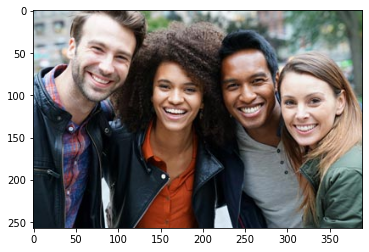

[rectangle(37,16,122,93), rectangle(215,55,302,133), rectangle(268,65,345,137), rectangle(135,58,219,134)]


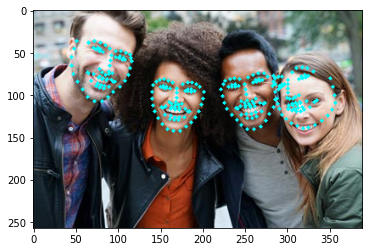

In [29]:
weightpath = os.path.join(PROJECT_PATH, 'training_checkpoints', 'weights_epoch_085.h5')
imagepath = os.path.join(PROJECT_PATH, 'image_people.png')


image, faces = predict_faces(model, weightpath, imagepath)
plt.imshow(image)
plt.show()
rects = convert_to_dlib_rects(image, faces)
print(rects)
landmarks = get_landmarks(image, rects, debug=True)

### Step 4. 스티커 합성 사진 생성하기

In [30]:
"""Calculate each nose points of the faces

Parameters
----------
dlib_rects : face bounding boxes from get_faces() method
landmarks  : face landmarks from get_landmarks() method
"""
NUM_NOSE = 30
def calculate_noses(dlib_rects, list_landmarks):
    noses = []
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        nose = {}
        nose['x'] = landmark[30][0]
        nose['y'] = landmark[30][1] - dlib_rect.height()//2
        nose['w'] = nose['h'] = dlib_rect.width()
        noses.append(nose)

    return noses

In [31]:
"""Calculate each angle of the faces

Parameters
----------
dlib_rects : face bounding boxes from get_faces() method
landmarks  : face landmarks from get_landmarks() method
"""
from math import atan2, degrees

NUM_LEFT_EYE = 36
NUM_RIGHT_EYE = 45
def calculate_angles(dlib_rects, list_landmarks):
    angles = []

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        l_eye_x = landmark[NUM_LEFT_EYE][0]
        l_eye_y = landmark[NUM_LEFT_EYE][1] - dlib_rect.height()//2

        r_eye_x = landmark[NUM_RIGHT_EYE][0]
        r_eye_y = landmark[NUM_RIGHT_EYE][1] - dlib_rect.height()//2
        w = h = dlib_rect.width()

        dx = r_eye_x - l_eye_x
        dy = r_eye_y - l_eye_y
        angle = degrees(atan2(dy, dx))
        angles.append(angle)

    return angles

In [32]:
"""Return RGB list of the input color

Parameters
----------
color : string value
"""
def get_color_code(color):
    rgb = [0, 0, 0]
    if color == 'red':
        rgb = [255, 0, 0]
    elif color == 'green':
        rgb = [0, 255, 0]
    elif color == 'blue':
        rgb = [0, 0, 255]
    elif color == 'pink':
        rgb = [251, 198, 207]
    else:
        rgb = [0, 0, 0]
    return rgb

In [33]:
def attach_stickers(image, sticker, noses, angles, color=None, debug=False):
    if len(noses) != len(angles):
        raise Exception(f'Invalid paramters, noses len: {len(noses)}, angles len: {len(angles)}')

    num_of_faces = len(noses)
    image_show = image.copy()

    if debug:
        print(f'noses {noses}')
        print(f'angles {angles}')
        
    for i in range(num_of_faces):
        ### sticker resize ###
        nose = noses[i]
        image_sticker = cv2.resize(sticker, (nose['w'],nose['h']))
        # target location
        x = nose['x'] - nose['w'] // 2
        y = nose['y']

        ### sticker rotate ###
        angle = angles[i]
        # 스티커의 높이와 너비
        (rotate_h, rotate_w) = image_sticker.shape[:2]
        center = (rotate_w // 2, rotate_h // 2)
        # 수염은 얼굴 각도랑 반대로 회전해줘야 하니깐 '-' 붙여줌
        rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        image_sticker = cv2.warpAffine(image_sticker, rotation_matrix,(nose['w'], nose['h']),
                                       flags=cv2.INTER_LINEAR,
                                       borderMode=cv2.BORDER_CONSTANT,
                                       borderValue=(255, 255, 255, 0))

        ### sticker omit ###
        # 이미지가 왼쪽이랑 위쪽으로 나갔을 때
        if x < 0:
            image_sticker = image_sticker[:, -x:]
            x = 0
        if y < 0:
            image_sticker = image_sticker[-y:, :]
            y = 0

        # 이미지가 오른쪽이랑 아래쪽으로 나갔을 때
        if x + image_sticker.shape[1] > image_show.shape[1]:
            excess_width = (x + image_sticker.shape[1]) - image_show.shape[1]
            image_sticker = image_sticker[:, :-excess_width]

        if y + image_sticker.shape[0] > image_show.shape[0]:
            excess_height = (y + image_sticker.shape[0]) - image_show.shape[0]
            image_sticker = image_sticker[:-excess_heigh
                                          , :]

        ### 이미지에 스티커 삽입 ###
        # rgb 색깔
        sticker_color = get_color_code(color)
        # apply
        sticker_area = image_show[y:y+image_sticker.shape[0], x:x+image_sticker.shape[1]]
        image_show[y:y +image_sticker.shape[0], x:x+image_sticker.shape[1]] = \
          np.where(image_sticker==0,sticker_color,sticker_area).astype(np.uint8)

    return image_show

In [34]:
def apply_sticker(model, weightpath, imagepath, sticker, color=None, debug=False):
    # 1. 이미지에서 얼굴 추출
    image, faces = predict_faces(model, weightpath, imagepath, debug=debug)
    rects = convert_to_dlib_rects(image, faces)
    # 2. 랜드마크 추출
    landmarks = get_landmarks(image, rects, debug=debug)
    # 3. 코 좌표 찾기
    noses = calculate_noses(rects, landmarks)
    # 4. 각도 계산
    angles = calculate_angles(rects, landmarks)
    # 5. 스티커 붙이기
    attached_image = attach_stickers(image, sticker, noses, angles, color, debug=debug)
    return attached_image

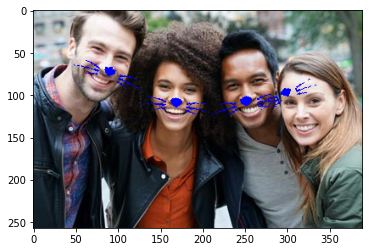

In [35]:
test_sticker = cv2.imread(os.path.join(PROJECT_PATH, 'mustache.png'))

weightpath = os.path.join(PROJECT_PATH, 'training_checkpoints', 'weights_epoch_085.h5')
imagepath = os.path.join(PROJECT_PATH, 'image_people.png')
image_with_sticker = apply_sticker(model, weightpath, imagepath, test_sticker, 'blue')
plt.imshow(image_with_sticker)
plt.show()

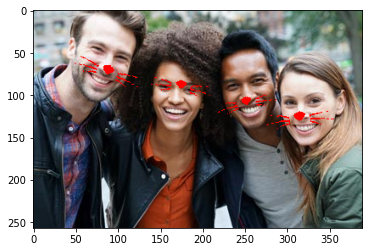

In [37]:
weightpath = os.path.join(PROJECT_PATH, 'lr_checkpoints', 'weights_epoch_095.h5')
imagepath = os.path.join(PROJECT_PATH, 'image_people.png')
image_with_sticker = apply_sticker(model, weightpath, imagepath, test_sticker, 'red')
plt.imshow(image_with_sticker)
plt.show()

### 회고
- 모델이 수렴은 하나, 로스 값이 조금 높은 것 같아서 로스를 수정해 봄
- 구현되어 있는 로스가 분류에 SparseCategoricalCrossentropy 이 부분을 고쳐봤음
- 분류는 focal loss를 사용하여 어느 정도 안정화가 된 것 같은데 로컬라이징은 불안정
- 로컬라이징에 Huber이 쓰여서 YOLO에 사용된 CIoU나 GIoU를 사용하려고 시도..
- Tensorflow Addons에 giou loss가 있어서 적용했는데 loss가 계속 1이 나옴..
  - giou는 바운딩 박스가 아예 겹치지 않을 때도 minmax 값을 구해서 union을 구하는건데, 이 부분에서 에러가 있었을듯
- 바운딩 박스의 위치가 부정확한 사람은 랜드마크 검출도 부정확